**Математические основы машинного обучения II**
*Домашнее задание №5. Поиск аномалий*
**Выполнила Савоськиной С.В.**

# 1. Импорт необходимых библиотек

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from plotly.subplots import make_subplots
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

# 2. Настройка параметров

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

# sns.set_style("whitegrid")
# sns.set(rc={'figure.figsize':(20, 5)})
pio.templates.default = "seaborn"

# 3. Код (вспомогательные методы)

In [57]:
RANDOM_STATE = 18
LOCAL_FOLDER = './data/'

TEST_SIZE = 0.3

# Столбцы, содержащие категориальные признаки
CAT_FEATURES=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
              'Utilities', 'LotConfig',  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
              'Exterior1st',  'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
              'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1',  'BsmtFinType2',
              'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageType', 'GarageFinish',  'GarageQual', 'GarageCond',
              'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Столбцы, содержащие числовые признаки
NUM_FEATURES=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
               'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
               'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

# Целевой признак для регрессии
TARGET_FEATURE = 'SalePrice'

# цвета для данных.
COLORS = np.array(["#377eb8","#ff7f00",  ])

def show_dataset_info(dataset):
    """
    Вывод основной информации о датасете
    :param dataset: Датасет для обработки
    :return: None
    """
    print(
    f"Размер набора данных: {dataset.shape}",
    f"Дупликатов: {dataset.duplicated().sum()}",
    f"Всего пропусков: {dataset.isna().sum().sum()}",
    f"Пропусков в столбцах: {dataset.loc[:,dataset.isna().sum()>0].isna().sum().sort_values()}",
    sep="\n"
)


def show_column_types(dataset):
    """
    Вывод числовых и категориальных столбцов в датасете
    :param dataset: Датасет для обработки
    :return: кортеж: список категориальных столбцов, список числовых столбцов
    """
    nums_df = dataset[NUM_FEATURES]
    cats_df = dataset[CAT_FEATURES]

    # выводим результат
    print('Категориальные признаки:\t ',cats_df.columns, '\n Число столбцов = ',len(cats_df.columns))
    print('Числовые признаки:\t ',  nums_df.columns, '\n Число столбцов = ',len(nums_df.columns))

    return cats_df.columns, nums_df.columns


def drop_feature(dataset, columns_to_drop, cat_columns, num_columns):
    """
    Удаление признаков (столбцов) из датасета
    :param dataset: Датасет для обработки
    :param columns_to_drop:  Столбцы для удаления
    :param cat_columns: Список категориальных столбцов
    :param num_columns: Список числовых столбцов
    :return: кортеж: новый список категориальных столбцов, новый список числовых столбцов
    """
    for col in columns_to_drop:
        print(f"Удаляется признак {col}")
        dataset.drop(col, axis=1, inplace=True, errors ="ignore")
        if cat_columns is not None:
            cat_columns = cat_columns.drop(col, errors ="ignore")
        if num_columns is not None:
            num_columns = num_columns.drop(col, errors ="ignore")

    return cat_columns, num_columns


def drop_corr_features(dataset, num_columns):
    """
    Удаление коррелирующих признаков
    :param dataset: Датасет для обработки
    :param num_columns: Числовые столбцы для обработки
    :return: кортеж: обработанный датасет, новый список числовых столбцов
    """
    correlations = dataset[num_columns.append(pd.Index([TARGET_FEATURE]))].corr()
    dropped=[]

    for row_idx, row in enumerate(correlations.index.drop([TARGET_FEATURE])):
        for col_idx in range(row_idx+1, len(correlations.index)):
            if (row_idx !=col_idx and row_idx not in dropped and col_idx not in dropped
                    and abs(correlations.iloc[row_idx, col_idx])>0.7):
                print(f"Признак {row} с признаком {correlations.columns[col_idx]} имеет коэффициент корреляции",
                   correlations.iloc[row_idx, col_idx])
                col_to_drop=[]
                if abs(correlations.loc[row, TARGET_FEATURE]) >= abs(correlations.iloc[col_idx, len(correlations.index)-1]):
                    col_to_drop.append(correlations.columns[col_idx])
                    dropped.append(col_idx)
                else:
                    col_to_drop.append(row)
                    dropped.append(row_idx)

                _, num_columns = drop_feature(dataset, col_to_drop, None, num_columns)

    return dataset, num_columns


def show_hist(dataset, columns, log_columns):
    """
    Показ гистограмм для нескольких столбцов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :param log_columns: столбцы, для которых необходимо выполнить логарифмирование
    :return: None
    """
    _cols = 4
    _rows = int(np.ceil(len(columns) / _cols))

    fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 28))
    ax = ax.flatten()

    for idx, column_name in enumerate(columns):
        hplot = sns.histplot(dataset, x= dataset[column_name], ax=ax[idx] ,
                             log_scale = column_name in log_columns, bins=16, color='lime')
        hplot.grid()

def search_outliers(feature):
    """
    Поиск выбросов в столбце
    :param feature: Столбец для обработки
    :return: количество выбросов в столбце
    """
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.where((feature < lower_bound) | (feature > upper_bound))[0]


def show_outliers(dataset, columns):
    """
    Вывод количества выбросов по столбцам
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: None
    """
    for col in columns:
        outliers=search_outliers(dataset[col])
        sum_outliers = len(outliers)
        print(f"Признак {col} содержит {sum_outliers} выбросов из {dataset[col].shape[0]} наблюдений ({sum_outliers/dataset[col].shape[0]*100:.2f}%)")


def drop_outliers(dataset, columns):
    """
    Удаление выбросов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: Датасет с удаленными выбросами
    """

    for col in columns:
        q1, q3 = np.percentile(dataset[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        sub_dataset=dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
        dataset = dataset.drop(sub_dataset.index)

    dataset = dataset.reset_index(drop=True)
    return dataset


def regression_metrics(pipeline, X_test, y_test):
    """
    Вывод метрик
    :param pipeline: обученный пайплайн обработки
    :param X_test: тестовая выборка
    :param y_test: значения целевой переменной для тестовой выборки
    :return: None
    """
    y_pred = pipeline.predict(X_test)
    print("r2_score: ", r2_score(y_test, y_pred))
    print("rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("mae: ", mean_absolute_error(y_test, y_pred))

def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label)
    markerline.set_markerfacecolor('none')


def cat_features(data: pd.DataFrame):
    return data.select_dtypes(exclude="number").columns

def num_features(data: pd.DataFrame):
    return data.select_dtypes(include="number").columns

def plot_hist(data, features, rows=3, title=""):
    _n_cols = int(np.ceil(len(features) / rows))
    fig = make_subplots(rows=rows, cols=_n_cols, subplot_titles=features)

    for idx, feature in enumerate(features):
        r = idx // _n_cols + 1
        c = idx % _n_cols + 1
        fig.add_histogram(
            x=data[feature],
            row=r, col=c,
            name=feature,
            histnorm='probability'
        )
        
    fig.update_layout(height=800, width=3200, title_text=title)
    fig.show()
    
def plot_scatter(data, features, y_name, rows=2, title="",
                 width=900, height=600):
    _num_features = len(features)
    _n_cols = int(np.ceil(_num_features / rows))
    fig = make_subplots(rows=rows, cols=_n_cols, subplot_titles=features)
    
    for idx, feature in enumerate(features):
        r = idx // _n_cols + 1
        c = idx % _n_cols + 1
        fig.add_scatter(
            x=data[feature],
            y=data[y_name],
            mode="markers",
            row=r, col=c,
            name=feature,
        )
        fig.update_yaxes(title=y_name)

    fig.update_layout(height=height, width=width, title_text=title)
    fig.show()
    
def plot_boxes(data, features, y_name, rows=2, title="",
                 width=900, height=600):
    _num_features = len(features)
    _n_cols = int(np.ceil(_num_features / rows))
    fig = make_subplots(rows=rows, cols=_n_cols, subplot_titles=features)
    
    for idx, feature in enumerate(features):
        r = idx // _n_cols + 1
        c = idx % _n_cols + 1
        fig.add_box(
            x=data[feature],
            y=data[y_name],
            row=r, col=c,
            name=feature,
        )
        fig.update_yaxes(title=y_name)

    fig.update_layout(height=height, width=width, title_text=title)
    fig.show()

def plot_datas(ax,X,n_inliers,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.5, s = 30, facecolor=True):
    """Визуализация двумерных  данных для поиска аномалий
    Входные переменные:
    ===========
    ax: отдельная ячейка объекта figure
    X: набор данных, содержащий признаки X
    n_inliers: количество нормальных данных
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """


    ax.set_title(name, fontsize = 30) # прописываем название графика
    ax.scatter(X.iloc[:n_inliers, 0], X.iloc[:n_inliers, 1],
                marker = marker, c=colors[0],
                s = s,
                alpha =alpha)
    ax.scatter(X.iloc[n_inliers:, 0], X.iloc[n_inliers:, 1],
            marker = marker, c=colors[1],
            s = s,
            alpha =alpha)
    # немного красоты и аккуратности
    x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

def viz_anomaly(data, algorithm, colors, n_inliers, response_method="auto"):
    """Визуализация принятия решений и данных
    Входные переменные:
    ===========
    data: данные которые будем визуализировать
    algorithm: Класс модели машинного обучения для которого мы хотим узнать границы решений
    colors: цвета, которые будут использоваться для раскраски разных классов
    n_inliers: количество нормальных точек в штуках
    response_method: что визуализируем, результаты метода decision_function, predict_proba или predict. auto перебирает первый возможный вариант
    """

    cm_bright = ListedColormap(colors[::-1]) # формируем цветовую карту из наших цветов

    # отрисовываем границу принятия решений с помощью Класса библиотеки scikit-learn
    disp = DecisionBoundaryDisplay.from_estimator(
        algorithm, # Какой алгоритм используем
        data, # на каких данных проверяем
        response_method=response_method, # что визуализируе
        cmap=cm_bright, # какую цветовую карту используем
        alpha=0.5, #прозрачность
    )

    # визуализируем просто данные с помощью нашей функции
    plot_datas(disp.ax_,data,n_inliers, colors = colors,)


# 4. Загрузка и подготовка данных
## 4.1. Загрузка данных

Загружаем датасет из https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [4]:
datafile = LOCAL_FOLDER + 'train.csv'
df = pd.read_csv(datafile, sep=',', index_col='Id',  low_memory=False)

df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1102,20,RL,61.0,9758,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,119500
20,20,RL,70.0,7560,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2009,COD,Abnorml,139000
322,60,RL,99.0,12099,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,354000
1025,20,RL,NaN,15498,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2008,COD,Abnorml,287000
326,45,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,87000


## 4.2. Информация о DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [6]:
show_dataset_info(df)

Размер набора данных: (1460, 80)
Дупликатов: 0
Всего пропусков: 7829
Пропусков в столбцах: Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


In [7]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
cat_columns, num_columns = show_column_types(df)

Категориальные признаки:	  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object') 
 Число столбцов =  46
Числовые признаки:	  Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'Bsmt

В датасете 1460 строки, 80 столбцов, часть из них текстовые, часть числовые. Большая часть столбцов, как числовых, так и строковых, содержат категориальные данные (это известно из описания датасета, не приведенного здесь). Категориальных столбцов - 46, числовых - 33.
Целевой столбец - SalePrice - цена продажи дома. Цена продажи дома варьируется от 34900 до 755000, средняя цена 180900, что немного выше медианного значения 163000, что говорит о небольшом преобладании домов с более низкой ценой.
Много пропусков в разных столбцах. Особенно много в столбцах LotFrontage (259), FireplaceQu (690), MasVnrType (872),
Fence (1179), Alley (1369), MiscFeature (1406), PoolQC (1453). Они будут удалены.
Дупликатов нет.


## 4.3. Предобработка данных

Удалим признаки для которых слишком много пропусков

In [9]:
columns_to_drop=df.columns[df.isna().sum()>400]
cat_columns, num_columns = drop_feature(df, columns_to_drop,cat_columns,num_columns)
show_dataset_info(df)

Удаляется признак Alley
Удаляется признак MasVnrType
Удаляется признак FireplaceQu
Удаляется признак PoolQC
Удаляется признак Fence
Удаляется признак MiscFeature
Размер набора данных: (1460, 74)
Дупликатов: 0
Всего пропусков: 860
Пропусков в столбцах: Electrical        1
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtExposure     38
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
LotFrontage     259
dtype: int64


Посмотрим на гистограммы числовых признаков.

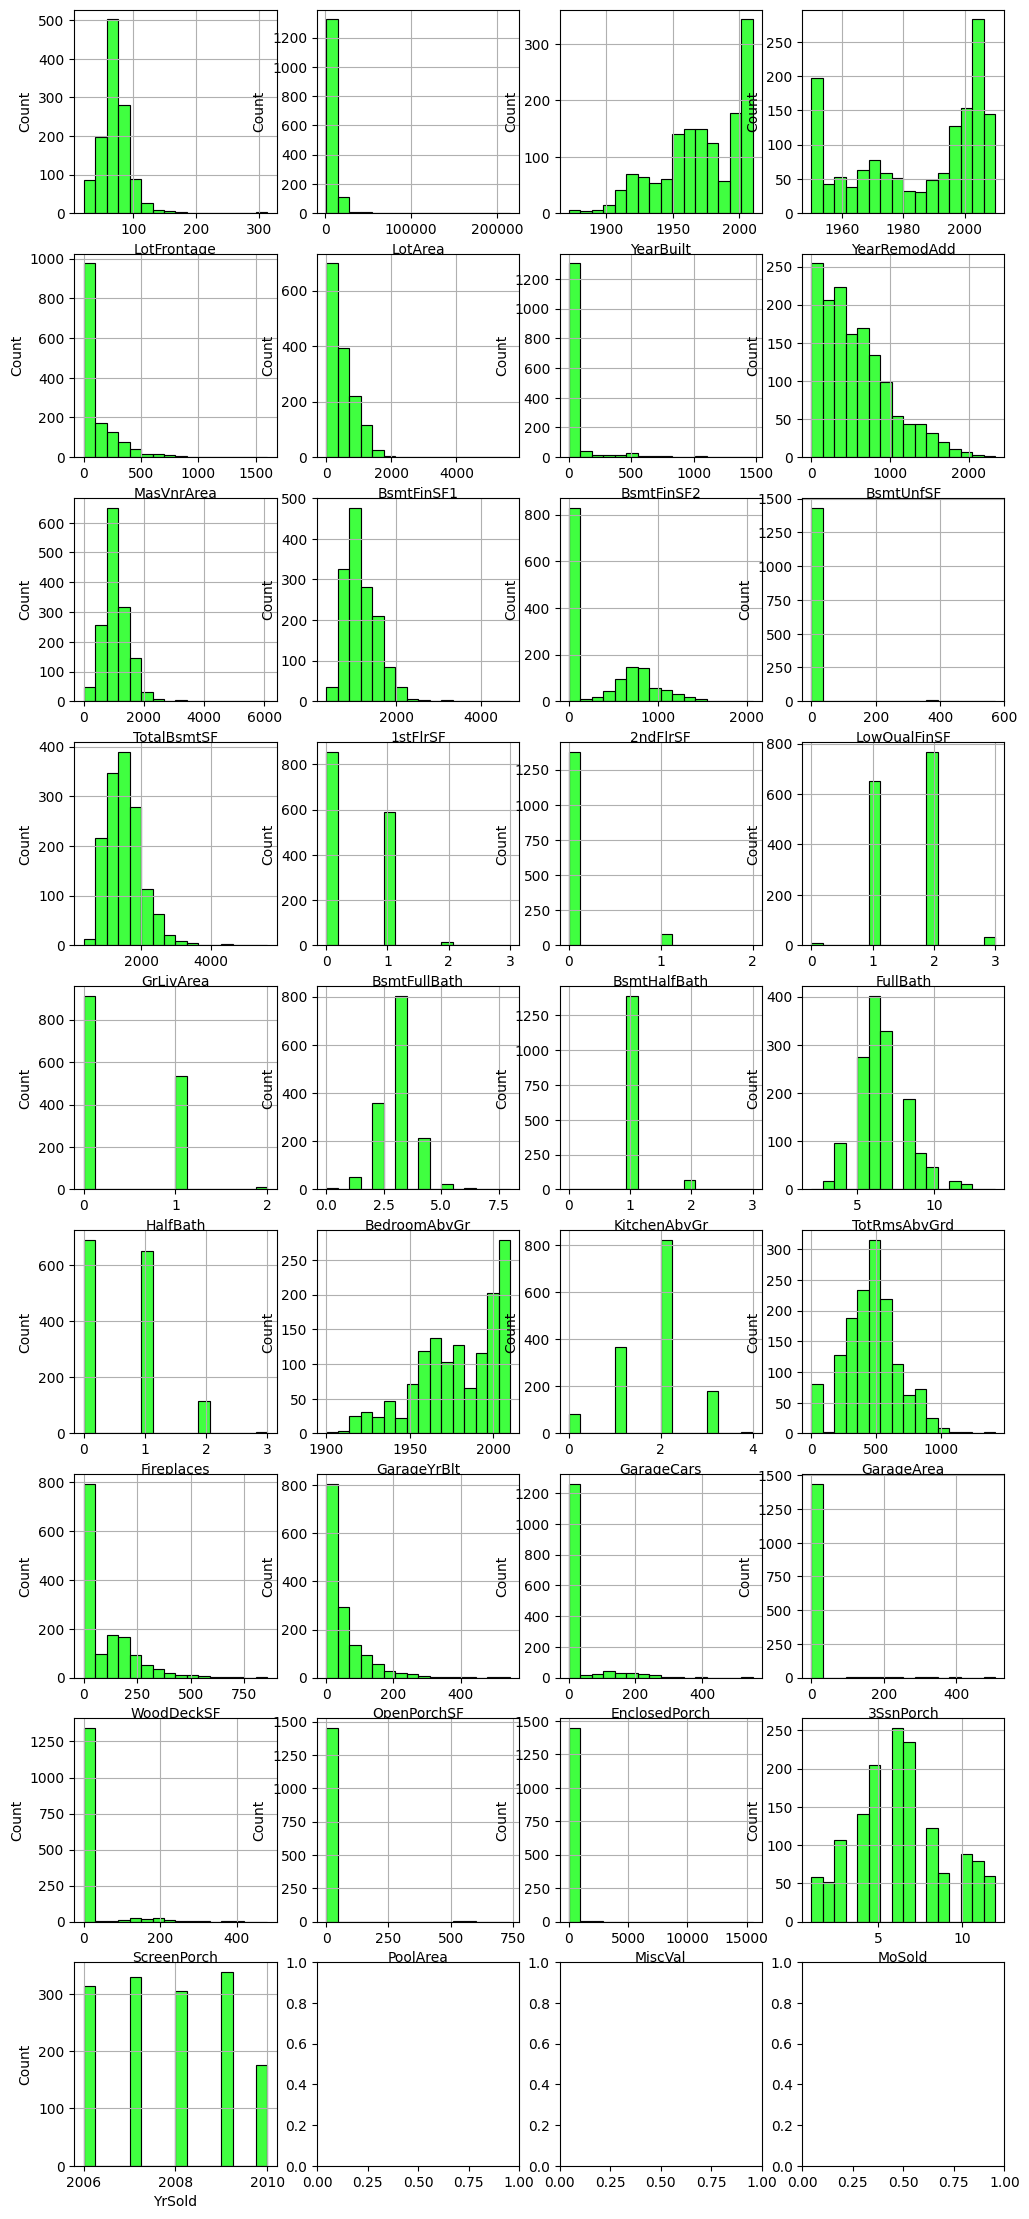

In [12]:
show_hist(df, num_columns, [])

Диаграмма размаха


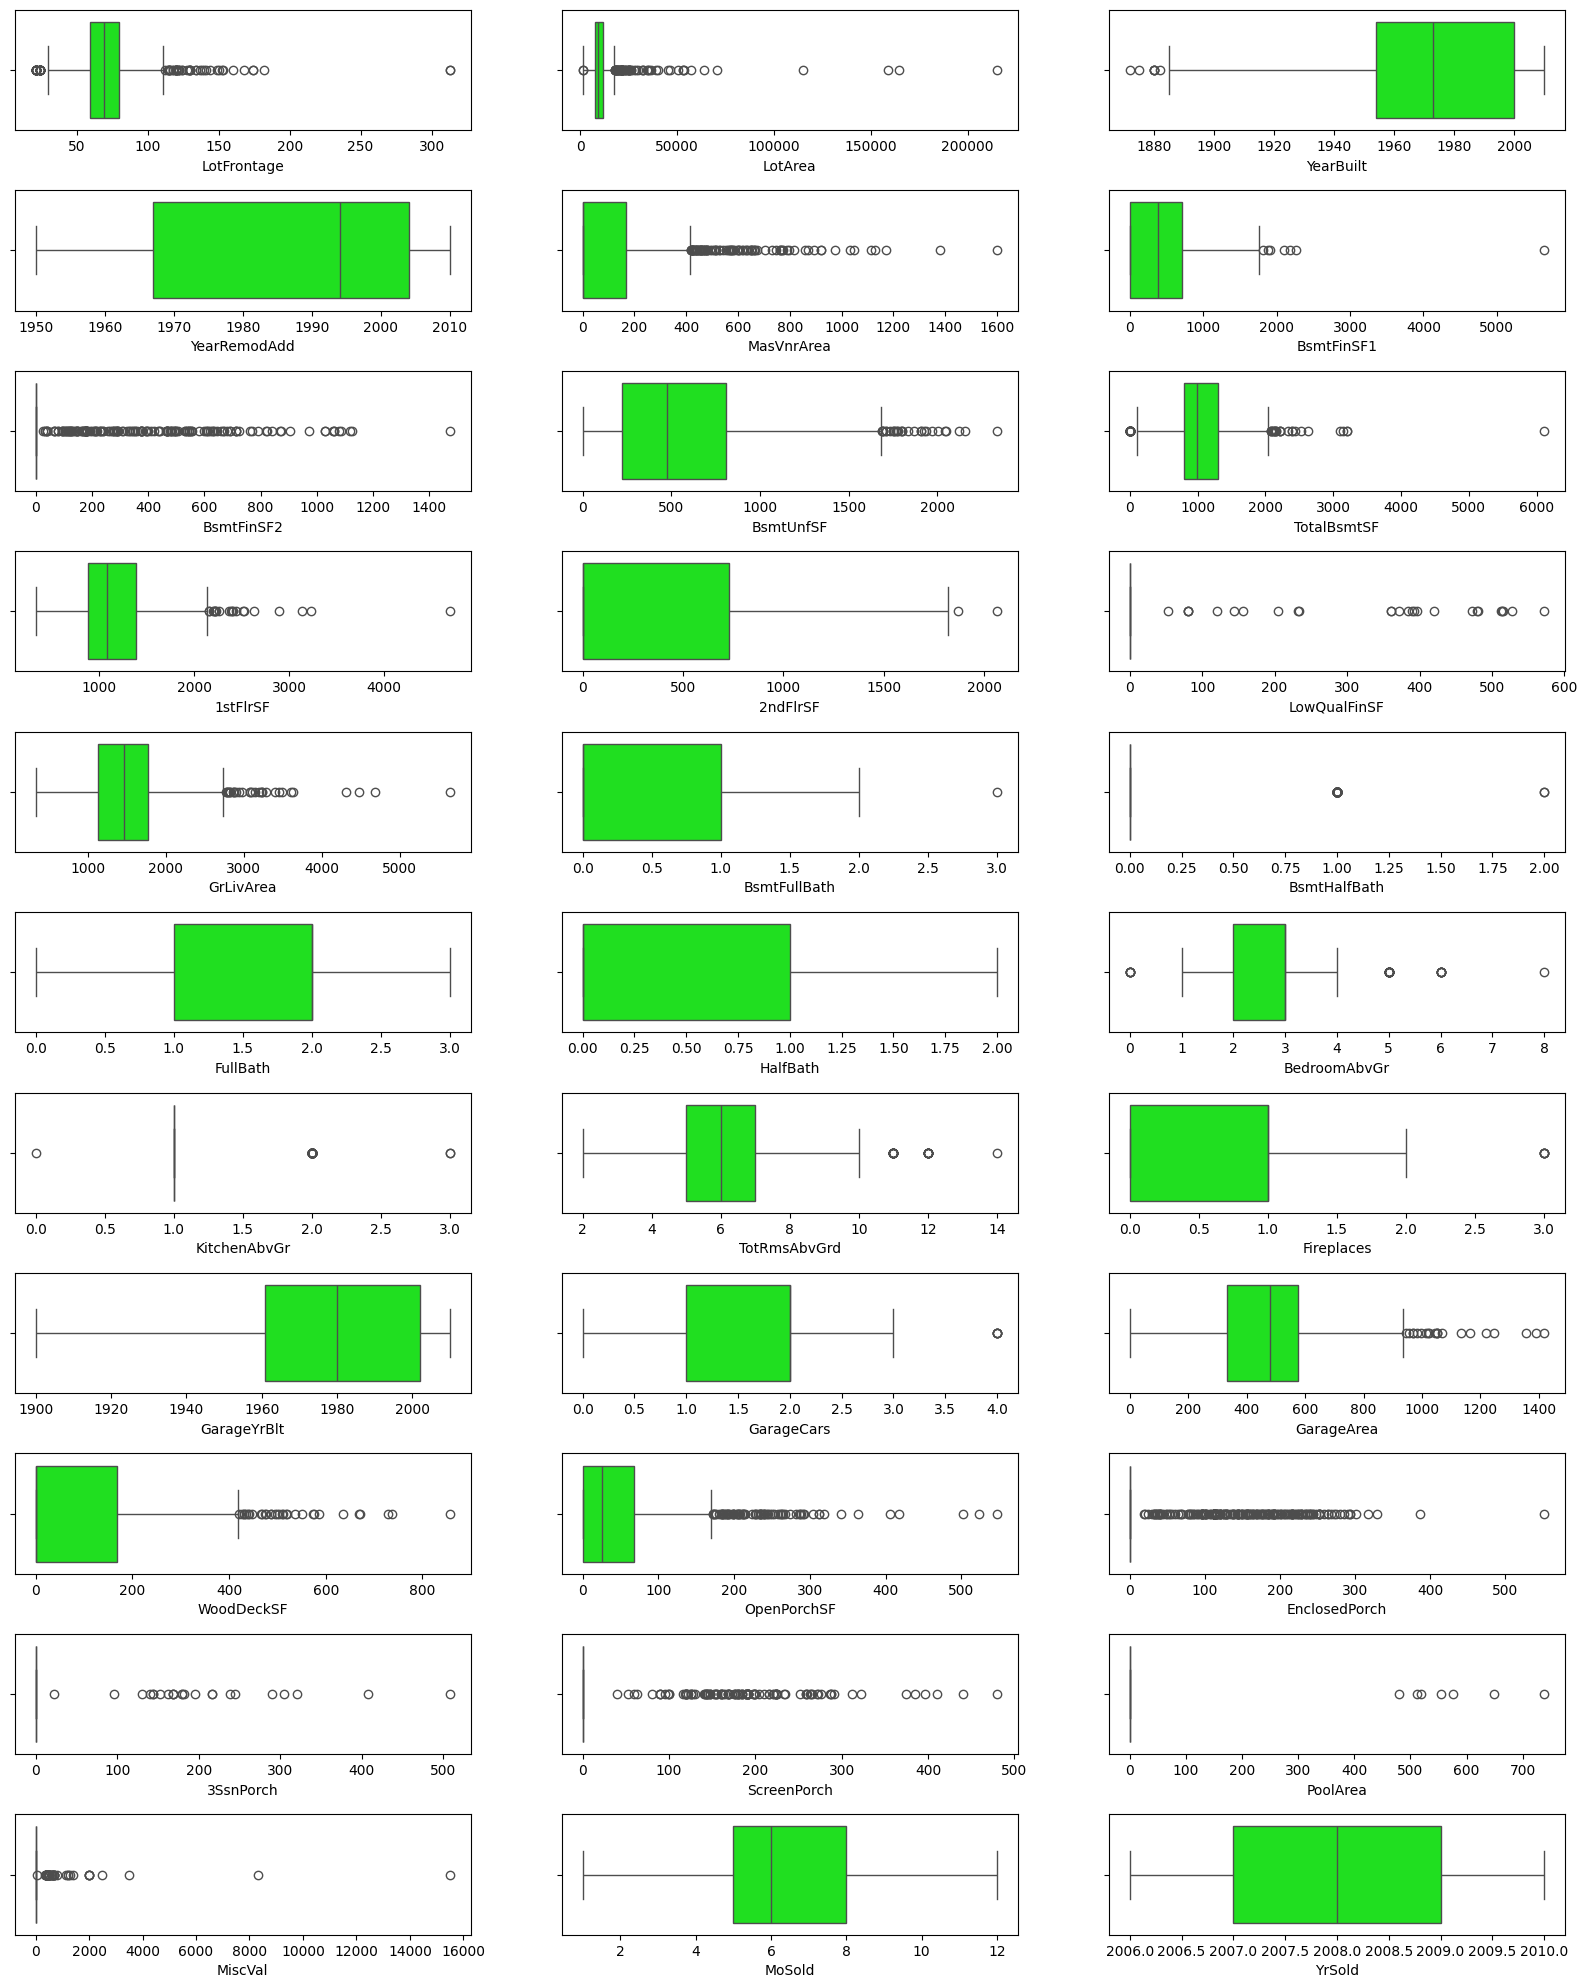

In [201]:
num=-1
rows=int(np.ceil(len(num_columns)/3))
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 25), gridspec_kw={'wspace':0.2,'hspace':0.5 })
plt.subplots_adjust(hspace=.3)
print("Диаграмма размаха")

for feature in num_columns:
    num = num+1
    x=num//3
    y=num -3*x
    sns.boxplot(data=df, x=feature, orient='h', color='lime', ax=axes[x,y])

Посмотрим количество выбросов по каждому признаку

In [14]:
show_outliers(df,num_columns)

Признак LotFrontage содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак LotArea содержит 69 выбросов из 1460 наблюдений (4.73%)
Признак YearBuilt содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак YearRemodAdd содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак MasVnrArea содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак BsmtFinSF1 содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак BsmtFinSF2 содержит 167 выбросов из 1460 наблюдений (11.44%)
Признак BsmtUnfSF содержит 29 выбросов из 1460 наблюдений (1.99%)
Признак TotalBsmtSF содержит 61 выбросов из 1460 наблюдений (4.18%)
Признак 1stFlrSF содержит 20 выбросов из 1460 наблюдений (1.37%)
Признак 2ndFlrSF содержит 2 выбросов из 1460 наблюдений (0.14%)
Признак LowQualFinSF содержит 26 выбросов из 1460 наблюдений (1.78%)
Признак GrLivArea содержит 31 выбросов из 1460 наблюдений (2.12%)
Признак BsmtFullBath содержит 1 выбросов из 1460 наблюдений (0.07%)
Признак BsmtHalfBath содержит 82 выбросов из 1460 наблюдений (5.62%)


Выбросы имеются.

# 5. Анализ аномалий

Исследовать на аномалии будем цену недвижимости.

## 5.1. Визуализация Данных

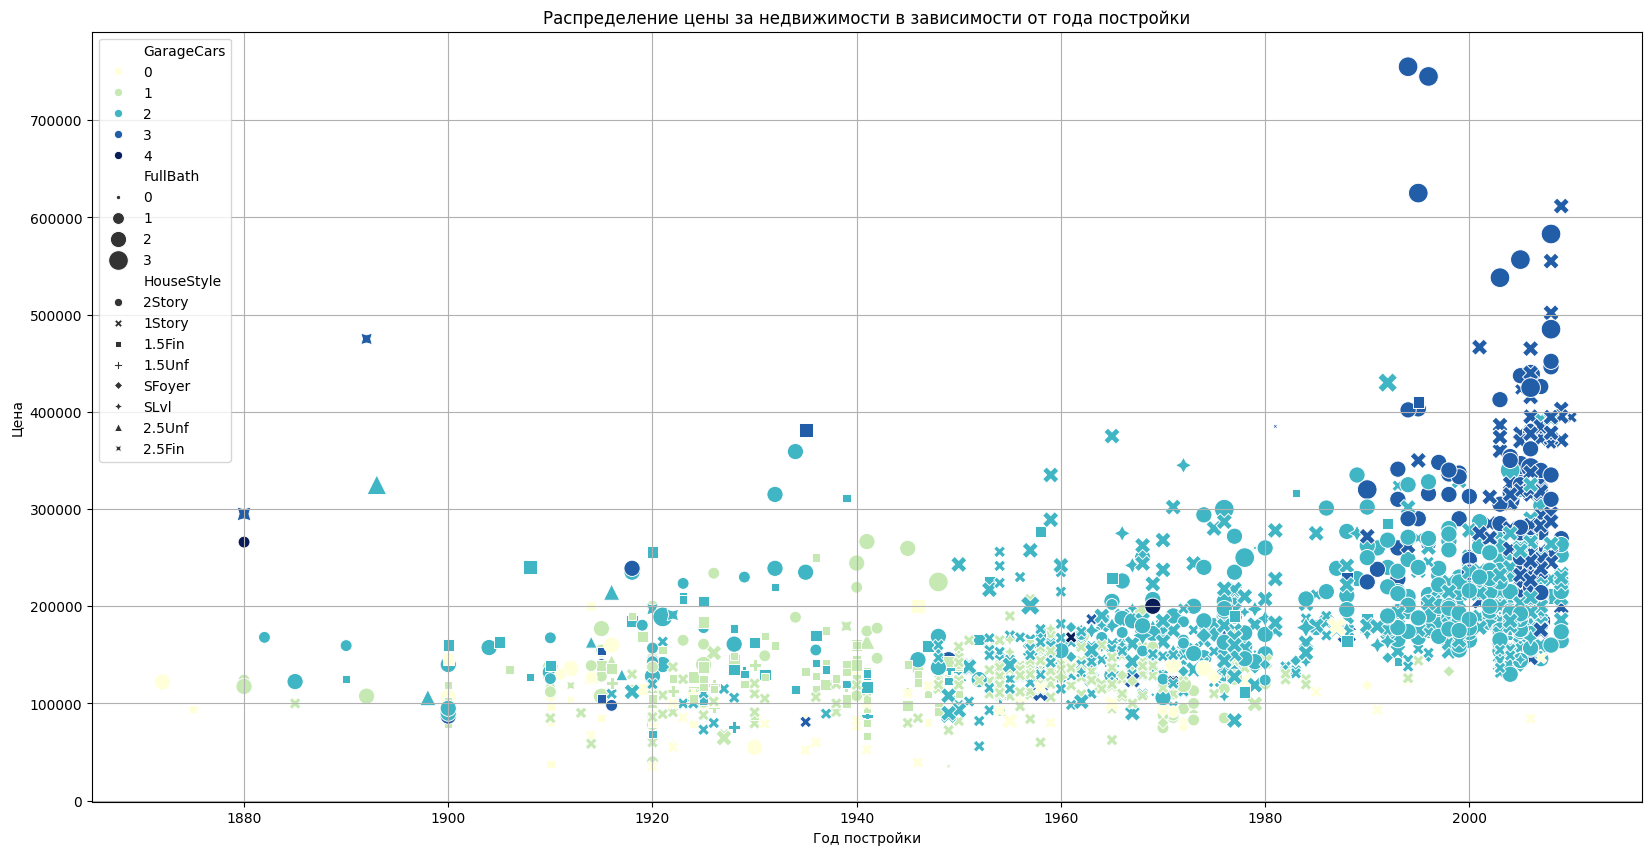

In [23]:
fig = plt.figure(figsize=(20, 10))
plot_data=sns.scatterplot(data=df,
                          x='YearBuilt',
                          y=TARGET_FEATURE,
                          style='HouseStyle',
                          hue="GarageCars",
                          palette="YlGnBu",
                          size="FullBath",
                          sizes=(10, 200) );
plot_data.set_title('Распределение цены за недвижимости в зависимости от года постройки');
plot_data.set_xlabel('Год постройки');
plot_data.set_ylabel('Цена');
plot_data.grid()

## 5.2. Подготовка данных

Данные будут содержать две составляющие: цена (SalePrice) и год постройки (YearBuilt)

In [51]:
X=df[[TARGET_FEATURE,'YearBuilt' ]]

X_train, X_test = train_test_split(X,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)
count_X=X.shape[0]

# 5.3. EllipticEnvelope

Гиперпараметры модели

In [177]:
# доля аномальных значений
contamination = 0.15
contamination+= 1e-6
count_norm=int(count_X*(1-contamination))

# Создаем объект класса
ell_env = EllipticEnvelope(contamination=contamination)
# Обучаем модель
ell_env.fit(X_train)

EllipticEnvelope(contamination=0.150001)

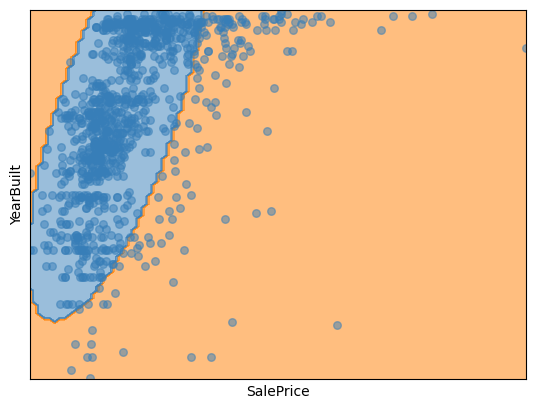

In [178]:
# визуализируем результат
viz_anomaly(X_train, ell_env, COLORS,count_norm, response_method="predict");

Параметры полученной модели:

Среднее

In [179]:
ell_env.location_

array([157913.87557604,   1970.12096774])

Ковариация

In [180]:
ell_env.covariance_

array([[2.21821050e+09, 9.42177136e+05],
       [9.42177136e+05, 8.19237671e+02]])

Какие данные использовались для оценки среднего и матрицы ковариации

In [181]:
ell_env.support_

array([False,  True,  True, ...,  True, False,  True])

Найдено всего аномалий:

In [182]:
count_X-ell_env.support_.sum()

592

In [183]:
df_train = pd.DataFrame({
    'SalePrice': X_train[TARGET_FEATURE],
    'YearBuilt': X_train['YearBuilt'] ,
    'EllipticEnvelope':ell_env.support_})

df_test = pd.DataFrame({
    'SalePrice': X_test[TARGET_FEATURE],
    'YearBuilt': X_test['YearBuilt'] ,
    'EllipticEnvelope':ell_env.predict(X_test)})

df_test['EllipticEnvelope']=df_test['EllipticEnvelope'].map({1: True, -1: False})

Распределение аномалий в тренировочной и тестовой выборках

In [184]:
gist_train=df_train[df_train.EllipticEnvelope==False]['SalePrice']
gist_test=df_test[df_test.EllipticEnvelope==False]['SalePrice']

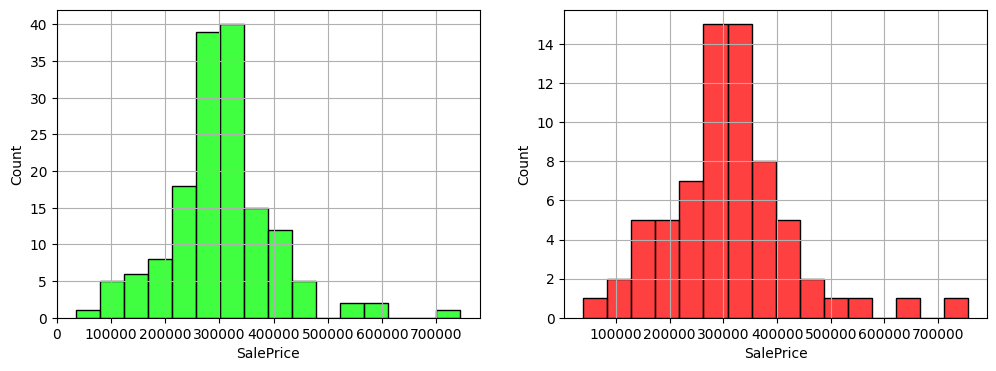

In [185]:
_cols = 2
_rows = 1

fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 4))
ax = ax.flatten()

hplot1 = sns.histplot(gist_train, bins=16, color='lime', ax=ax[0])
hplot1.grid()
hplot2 = sns.histplot(gist_test, bins=16, color='red',ax=ax[1])
hplot2.grid()

# 5.4. IsolationForest

Гиперпараметры модели

In [133]:
# доля аномальных значений
contamination = 0.1
contamination += 1e-6
# Количество деревьев
n_estimators =  100
count_norm=int(count_X*(1-contamination))

# Создаем объект класса
iso_forest = IsolationForest(
    contamination=contamination,
    n_estimators = n_estimators,
    random_state=RANDOM_STATE)

# Обучаем модель
iso_forest.fit(X_train)

IsolationForest(contamination=0.100001, random_state=18)

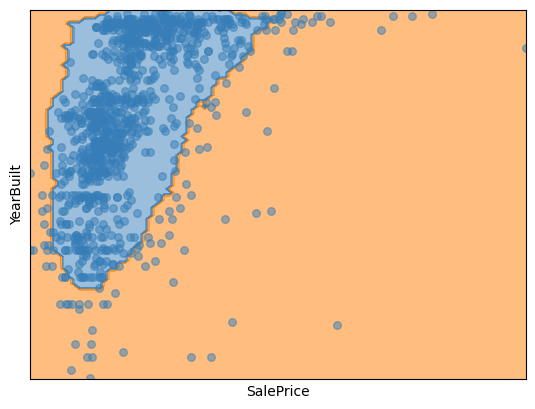

In [134]:
viz_anomaly(X_train, iso_forest, COLORS,count_norm, response_method="predict");

Параметры полученной модели:

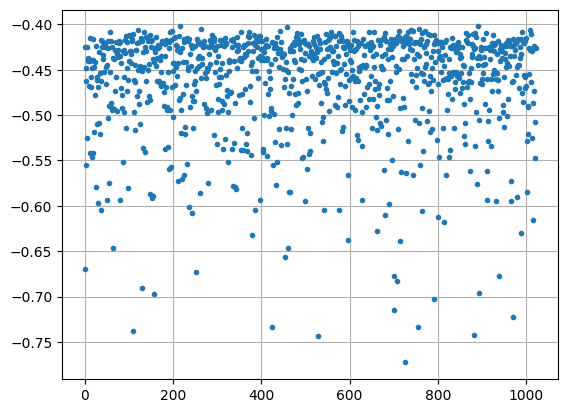

In [135]:
plt.plot(iso_forest.score_samples(X_train),'.',)
plt.title='Показатели аномальности для всех значений датасета'
plt.xlabel='Номер значения'
plt.ylabel='Показатель аномальности'
plt.grid();

In [186]:
df_train['IsolationForest_score']=iso_forest.score_samples(X_train)
df_train['IsolationForest']= iso_forest.predict(X_train)

df_train['IsolationForest']=df_train['IsolationForest'].map({1: True, -1: False})
df_train

,SalePrice,YearBuilt,EllipticEnvelope,IsolationForest_score,IsolationForest
Id,,,,,
631,124000,1880,False,-0.670017,False
178,172500,1958,True,-0.424660,True
637,60000,1936,True,-0.555088,False
563,108000,1940,True,-0.448140,True
260,97000,1956,True,-0.462561,True
...,...,...,...,...,...
1199,178000,2001,True,-0.423660,True
838,100000,1973,True,-0.473862,True
1145,80000,1941,True,-0.507261,True


Найдено всего аномалий:

In [188]:
len(X_train) - df_train.IsolationForest.sum()

103

In [190]:
gist_train=df_train[df_train.IsolationForest==False]['SalePrice']

Результаты на тестовой выборке:

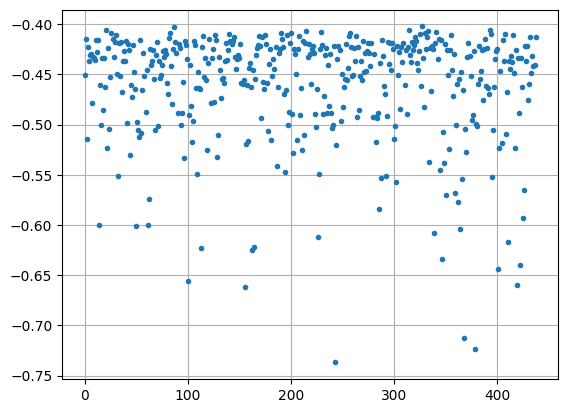

In [139]:
plt.plot(iso_forest.score_samples(X_test),'.',)
plt.title='Показатели аномальности для всех значений датасета'
plt.xlabel='Номер значения'
plt.ylabel='Показатель аномальности'
plt.grid();

Сравнение аномалий в тренировочной и тестовой выборках

In [192]:
df_test['IsolationForest_score']=iso_forest.score_samples(X_test)
df_test['IsolationForest']= iso_forest.predict(X_test)
df_test['IsolationForest']=df_test['IsolationForest'].map({1: True, -1: False})

df_test

,SalePrice,YearBuilt,EllipticEnvelope,IsolationForest_score,IsolationForest
Id,,,,,
1414,257000,2005,True,-0.450365,True
667,129000,1965,True,-0.414786,True
886,328900,1999,False,-0.514776,True
994,173900,2005,True,-0.423247,True
789,107900,1954,True,-0.437070,True
...,...,...,...,...,...
956,145000,1946,True,-0.448584,True
417,149500,1978,True,-0.431587,True
867,248900,2006,True,-0.441485,True


Найдено всего аномалий:

In [193]:
len(X_test) - df_test.IsolationForest.sum()

37

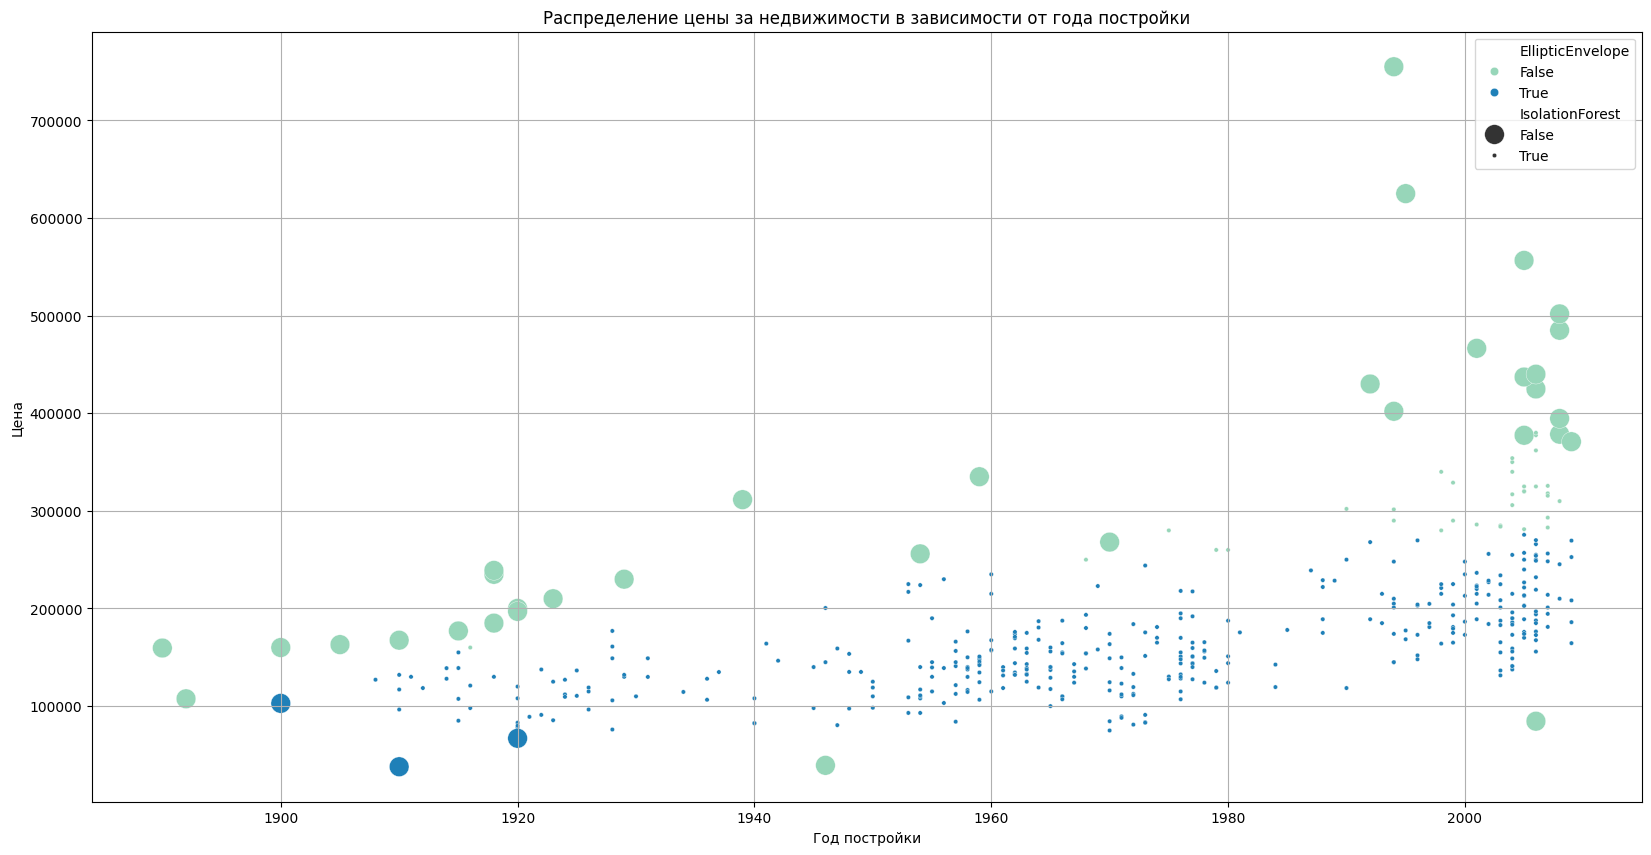

In [194]:
fig = plt.figure(figsize=(20, 10))
plot_data=sns.scatterplot(data=df_test,
                          x='YearBuilt',
                          y=TARGET_FEATURE,
                          # style='IsolationForest',
                          hue="EllipticEnvelope",
                          palette="YlGnBu",
                          size="IsolationForest",
                          sizes=(10, 200) );
plot_data.set_title('Распределение цены за недвижимости в зависимости от года постройки');
plot_data.set_xlabel('Год постройки');
plot_data.set_ylabel('Цена');
plot_data.grid()

Распределение аномалий в тренировочной и тестовой выборках

In [196]:
gist_test=df_test[df_test.IsolationForest==False]['SalePrice']

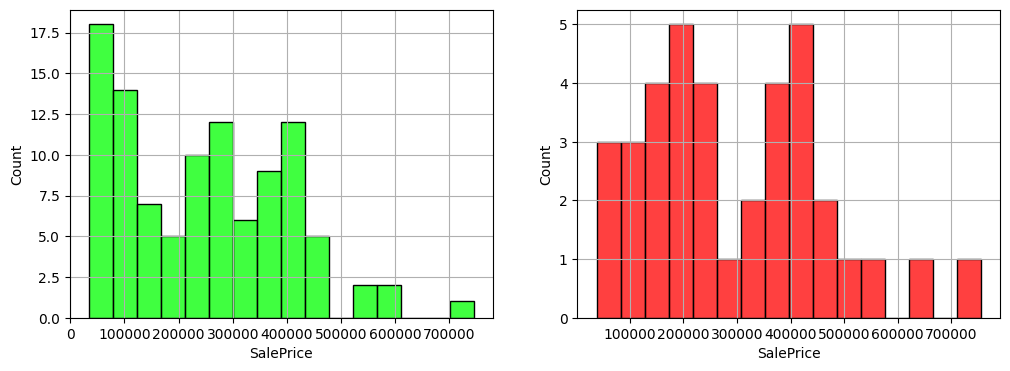

In [197]:
_cols = 2
_rows = 1

fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 4))
ax = ax.flatten()

hplot1 = sns.histplot(gist_train, bins=16, color='lime', ax=ax[0])
hplot1.grid()
hplot2 = sns.histplot(gist_test, bins=16, color='red',ax=ax[1])
hplot2.grid()

# Выводы
1. Метод EllipticEnvelope находит аномалии, которые имеют нормальное распределение. Аномалии, найденные методом
IsolationForest, определенного распределения не имеют.
2. При равных параметрах гиперпараметрах (contamination) метод EllipticEnvelope находит больше аномалий, чем метод
IsolationForest.
3. Оба метода в большинстве случаев аномалиями считают слишком высокую цену за недвижимость.